<a href="https://colab.research.google.com/github/Vasco2510/CA2_PriceCalculator/blob/main/Offical_Collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculadora Inteligente de Envíos
##1. **Identificar el problema**
- **Objetivo principal**: construir una **calculadora de envíos** para una tienda online.  
- **Funciones clave**:  
  - Predecir **tiempo de entrega**.  
  - Predecir **costo de envío**.  
  - Predecir **probabilidades** de cumplimiento
- **Comparación de opciones**:  
  - **Express** vs **Estándar** vs **Económico**.  
  - Mostrar sus **probabilidades de cumplimiento**.  
  - Incluir **rangos de incertidumbre**.  
- **Desafío principal**:  
  - Presentar múltiples variables de forma **clara y comparativa**.  
  - Manejar incertidumbre **sin generar desconfianza**.  
  - Adaptar presentación según el **contexto del usuario**:  
    - Caso **urgente** → optimizar rapidez.  
    - Caso **económico** → optimizar costo.  


## Dataset
https://www.kaggle.com/datasets/ziya07/smart-logistics-supply-chain-dataset

- Empresa de logística/envíos (FedEx, Amazon, etc)
- Info en tiempo real de la cadena de suministros

## Toolkit
- Git
- Streamlit o FLET
- Logging

### **Diccionario de datos**:
- Timestamp: Date and time when the data was recorded, representing logistics activity.
- Asset_ID: Unique identifier for the logistical assets (e.g., trucks).
- Latitude & Longitude: Geographical coordinates of the asset for tracking and monitoring.
- Inventory_Level: Current level of inventory associated with the asset or shipment.
- Shipment_Status: Status of the shipment (e.g., In Transit, Delivered, Delayed).
- Temperature: Temperature recorded at the time of the shipment or transportation.
- Humidity: Humidity level at the time of recording.
- Traffic_Status: Current traffic condition (e.g., Clear, Heavy, Detour).
- **Waiting_Time:** Time spent waiting during the logistics process (in minutes).
- User_Transaction_Amount: Monetary amount associated with user transactions.
- User_Purchase_Frequency: Frequency of purchases made by the user.
- Logistics_Delay_Reason: Reason for any delays in the logistics process (e.g., Weather, Mechanical Failure).
- Asset_Utilization: Percentage of asset utilization, indicating how effectively assets are being used.
- **Demand_Forecast:** Predicted demand for the logistics services in the coming period.
- **Logistics_Delay** (Target): Binary variable indicating whether a logistics delay occurred (1 for delay, 0 for no delay).


##2. **Adquisicion de datos**


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime



In [6]:
df = pd.read_csv('smart_logistics_dataset.csv')

# Información inicial del dataset
print("Dimensiones del dataset:", df.shape)
print("\nInformación del dataset:")
print(df.info())
print("\nPrimeras 5 filas:")
print(df.head())

Dimensiones del dataset: (1000, 16)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                1000 non-null   object 
 1   Asset_ID                 1000 non-null   object 
 2   Latitude                 1000 non-null   float64
 3   Longitude                1000 non-null   float64
 4   Inventory_Level          1000 non-null   int64  
 5   Shipment_Status          1000 non-null   object 
 6   Temperature              1000 non-null   float64
 7   Humidity                 1000 non-null   float64
 8   Traffic_Status           1000 non-null   object 
 9   Waiting_Time             1000 non-null   int64  
 10  User_Transaction_Amount  1000 non-null   int64  
 11  User_Purchase_Frequency  1000 non-null   int64  
 12  Logistics_Delay_Reason   737 non-null    object 
 13  Asset_Utilization

##3. **Preparación de datos**
### 3.1 Limpieza de Datos


In [7]:
# Verificar valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

# Verificar duplicados
print(f"\nNúmero de duplicados: {df.duplicated().sum()}")

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df.describe())

Valores nulos por columna:
Timestamp                    0
Asset_ID                     0
Latitude                     0
Longitude                    0
Inventory_Level              0
Shipment_Status              0
Temperature                  0
Humidity                     0
Traffic_Status               0
Waiting_Time                 0
User_Transaction_Amount      0
User_Purchase_Frequency      0
Logistics_Delay_Reason     263
Asset_Utilization            0
Demand_Forecast              0
Logistics_Delay              0
dtype: int64

Número de duplicados: 0

Estadísticas descriptivas:
          Latitude    Longitude  Inventory_Level  Temperature     Humidity  \
count  1000.000000  1000.000000      1000.000000  1000.000000  1000.000000   
mean     -1.360093     0.837049       297.915000    23.893900    65.042200   
std      51.997183   104.843618       113.554773     3.322178     8.753765   
min     -89.791500  -179.820200       100.000000    18.000000    50.000000   
25%     -46.167975   

### 3.2 Feature Engineering
- Se requiere feature engineering para inferir variables objetivo como costo de envío (10% de User_Transaction_Amount, mínimo 10 soles). Esto tiene fundamento pues el costo de los envios suele tener alta relación con el costo del pedido, al tiempo que existen pedidos mínimos. Asimismo por cuestiones de simplificación del caso, no se asumirá la existencia de envios gratuitos por alto monto de pedido del cliente. Sin embargo, se recomienda para futuras investigaciones, tomar este punto.
- La variable Timestamp tiene información clave sobre el tiempo pero debe ser preprocesada para que sea entendible y útil para entrenar modelos de ML.



In [8]:
# Crear variable de costo de envío (10% de User_Transaction_Amount, mínimo 10 soles)
df['Shipping_Cost'] = df['User_Transaction_Amount'] * 0.10
df['Shipping_Cost'] = df['Shipping_Cost'].apply(lambda x: max(x, 10))

# Extraer características de timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month
df['Is_Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Codificación de variables categóricas
from sklearn.preprocessing import LabelEncoder

# Codificar Asset_ID (puede ser útil para algunos modelos)
le_asset = LabelEncoder()
df['Asset_ID_Encoded'] = le_asset.fit_transform(df['Asset_ID'])

# One-Hot Encoding para Traffic_Status
traffic_dummies = pd.get_dummies(df['Traffic_Status'], prefix='Traffic')
df = pd.concat([df, traffic_dummies], axis=1)

# One-Hot Encoding para Logistics_Delay_Reason
delay_dummies = pd.get_dummies(df['Logistics_Delay_Reason'], prefix='Delay_Reason')
df = pd.concat([df, delay_dummies], axis=1)

# Variable objetivo para tiempo de entrega (usando Waiting_Time)
df['Delivery_Time'] = df['Waiting_Time']

print("Nuevas características creadas:")
print(df[['Shipping_Cost', 'Hour', 'DayOfWeek', 'Is_Weekend']].head())

Nuevas características creadas:
   Shipping_Cost  Hour  DayOfWeek  Is_Weekend
0           32.0     0          2           0
1           43.9     7          2           0
2           35.5    18          0           0
3           22.7     0          0           0
4           19.7    15          4           0


### 3.3 Selección de Variables Finales


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Timestamp                        1000 non-null   datetime64[ns]
 1   Asset_ID                         1000 non-null   object        
 2   Latitude                         1000 non-null   float64       
 3   Longitude                        1000 non-null   float64       
 4   Inventory_Level                  1000 non-null   int64         
 5   Shipment_Status                  1000 non-null   object        
 6   Temperature                      1000 non-null   float64       
 7   Humidity                         1000 non-null   float64       
 8   Traffic_Status                   1000 non-null   object        
 9   Waiting_Time                     1000 non-null   int64         
 10  User_Transaction_Amount          1000 non-null   int64       

In [15]:
# Variables para el modelado
features = [
    'Latitude', 'Longitude', 'Inventory_Level', 'Temperature', 'Humidity',
    'User_Transaction_Amount', 'User_Purchase_Frequency', 'Asset_Utilization',
    'Demand_Forecast', 'Hour', 'DayOfWeek', 'Month', 'Is_Weekend',
    'Asset_ID_Encoded', 'Traffic_Clear', 'Traffic_Heavy', 'Traffic_Detour', 'Delay_Reason_Weather', 'Delay_Reason_Traffic',
    'Delay_Reason_Mechanical Failure'
]

target_time = 'Delivery_Time'
target_cost = 'Shipping_Cost'
target_delay = 'Logistics_Delay'

print(f"Total de variables predictoras: {len(features)}")

Total de variables predictoras: 20


## 4. Análisis Exploratorio de Datos (EDA)
### 4.1 Distribución de Variables Principales



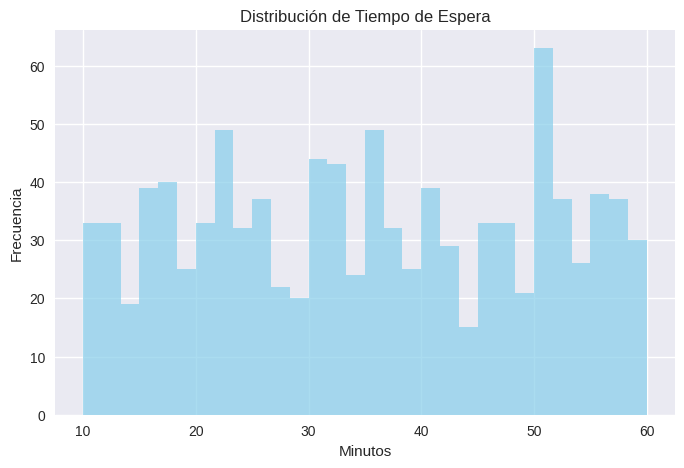

In [19]:

plt.style.use('seaborn-v0_8')

# Distribución de Waiting_Time
plt.figure(figsize=(8,5))
plt.hist(df['Waiting_Time'], bins=30, alpha=0.7, color='skyblue')
plt.title('Distribución de Tiempo de Espera')
plt.xlabel('Minutos')
plt.ylabel('Frecuencia')
plt.show()

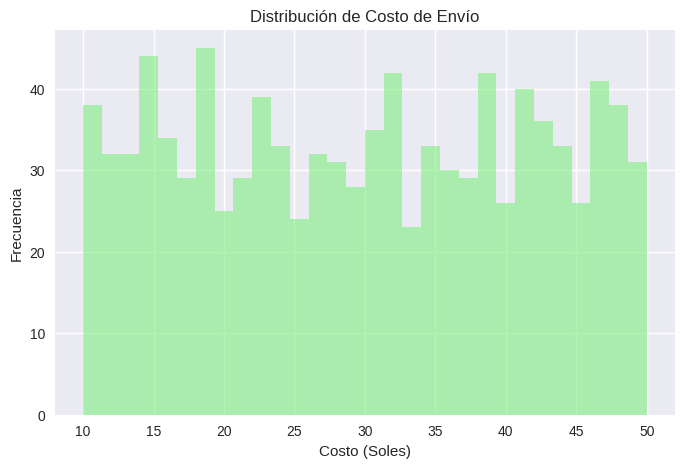

In [20]:
# Distribución de Shipping_Cost
plt.figure(figsize=(8,5))
plt.hist(df['Shipping_Cost'], bins=30, alpha=0.7, color='lightgreen')
plt.title('Distribución de Costo de Envío')
plt.xlabel('Costo (Soles)')
plt.ylabel('Frecuencia')
plt.show()

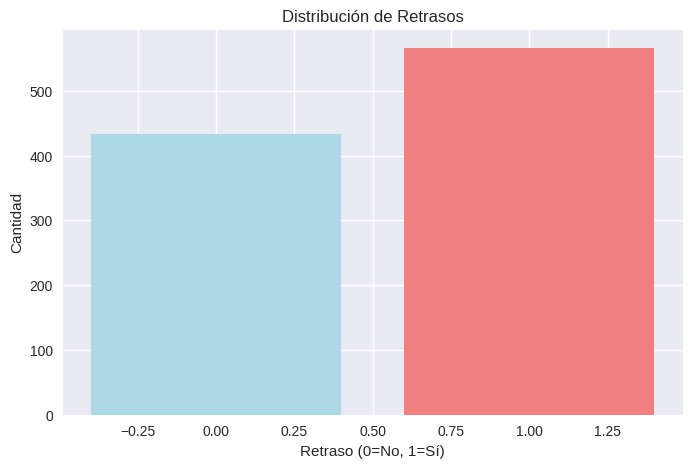

In [21]:
# Distribución de Logistics_Delay
plt.figure(figsize=(8,5))
delay_counts = df['Logistics_Delay'].value_counts()
plt.bar(delay_counts.index, delay_counts.values, color=['lightcoral', 'lightblue'])
plt.title('Distribución de Retrasos')
plt.xlabel('Retraso (0=No, 1=Sí)')
plt.ylabel('Cantidad')
plt.show()

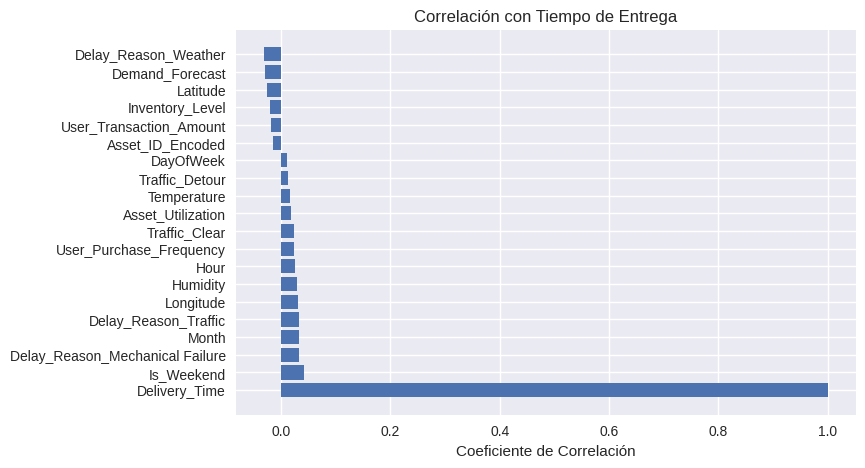

In [22]:
# Correlación con Waiting_Time
plt.figure(figsize=(8,5))
corr_with_time = df[[f for f in features if f in df.columns] + [target_time]].corr()[target_time].sort_values(ascending=False)
plt.barh(range(len(corr_with_time[:-1])), corr_with_time[:-1].values)
plt.yticks(range(len(corr_with_time[:-1])), corr_with_time.index[:-1])
plt.title('Correlación con Tiempo de Entrega')
plt.xlabel('Coeficiente de Correlación')
plt.show()

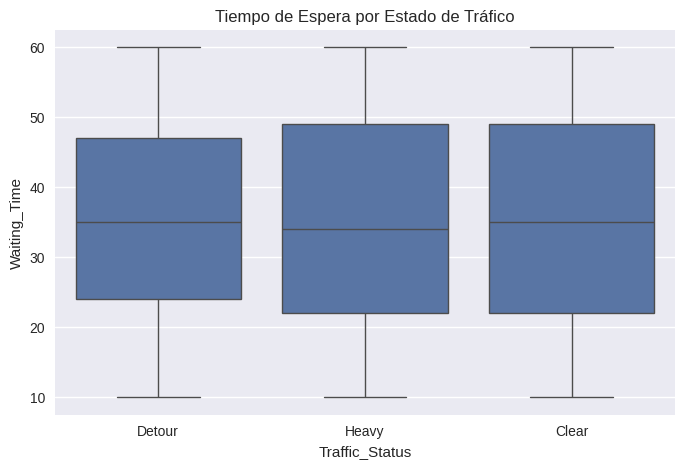

In [23]:
# Boxplot de Waiting_Time por Traffic_Status
plt.figure(figsize=(8,5))
sns.boxplot(x='Traffic_Status', y='Waiting_Time', data=df)
plt.title('Tiempo de Espera por Estado de Tráfico')
plt.show()


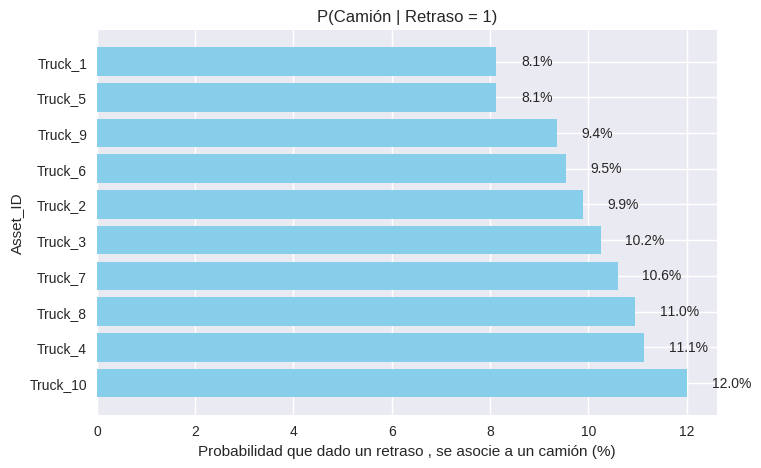

In [33]:

# Probabilidad P(Camión | Retraso = 1) en porcentaje
delay_by_asset = (
    df[df['Logistics_Delay'] == 1]['Asset_ID']
    .value_counts(normalize=True)           # proporciones
    .head(10) * 100                         # convertir a %
)

plt.figure(figsize=(8,5))
plt.barh(delay_by_asset.index, delay_by_asset.values, color='skyblue')
plt.title("P(Camión | Retraso = 1)")
plt.xlabel("Probabilidad que dado un retraso , se asocie a un camión (%)")
plt.ylabel("Asset_ID")

# Mostrar los valores al lado de cada barra
for i, v in enumerate(delay_by_asset.values):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

plt.show()


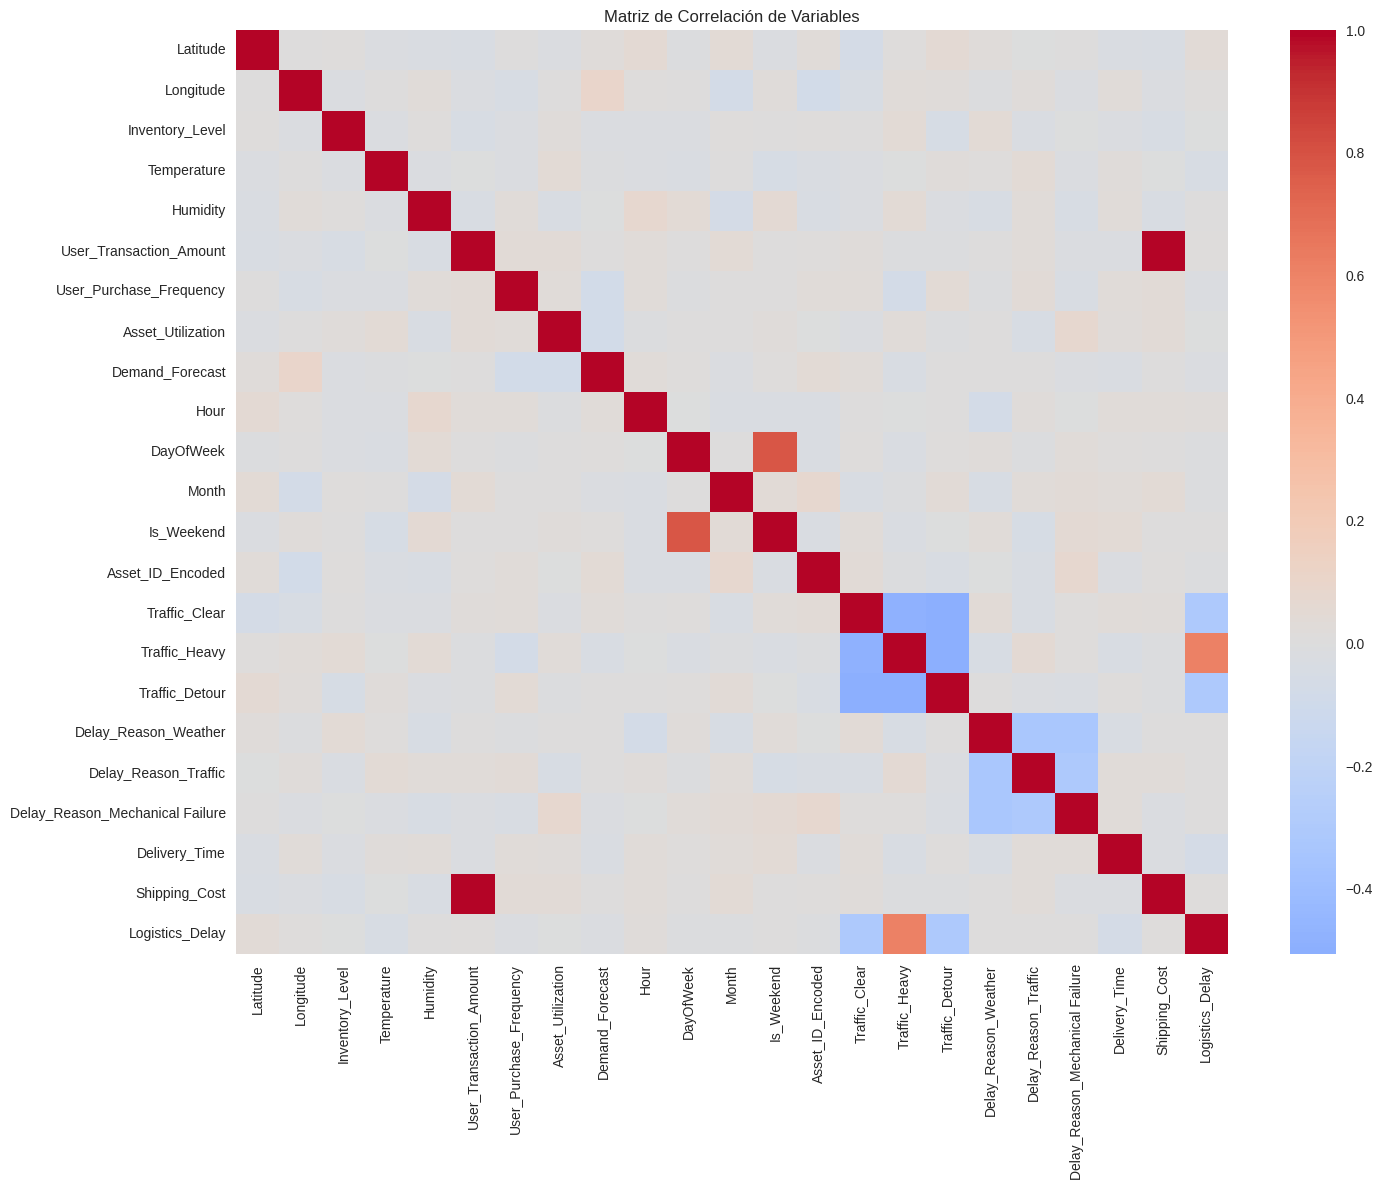

Correlaciones con Tiempo de Entrega:
Delivery_Time                      1.000000
Is_Weekend                         0.042559
Delay_Reason_Mechanical Failure    0.032726
Month                              0.032413
Delay_Reason_Traffic               0.032121
Longitude                          0.031938
Humidity                           0.029030
Hour                               0.025313
User_Purchase_Frequency            0.023582
Traffic_Clear                      0.023207
Name: Delivery_Time, dtype: float64

Correlaciones con Costo de Envío:
User_Transaction_Amount    1.000000
Shipping_Cost              1.000000
Month                      0.043965
Asset_Utilization          0.038607
User_Purchase_Frequency    0.038406
Delay_Reason_Traffic       0.032227
Hour                       0.025531
Traffic_Clear              0.019286
Asset_ID_Encoded           0.016176
Logistics_Delay            0.013605
Name: Shipping_Cost, dtype: float64

Correlaciones con Retraso:
Logistics_Delay             

In [30]:
# Matriz de correlación
correlation_matrix = df[features + [target_time, target_cost, target_delay]].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Variables')
plt.show()

# Correlaciones más fuertes con variables objetivo
print("Correlaciones con Tiempo de Entrega:")
print(correlation_matrix[target_time].sort_values(ascending=False).head(10))

print("\nCorrelaciones con Costo de Envío:")
print(correlation_matrix[target_cost].sort_values(ascending=False).head(10))

print("\nCorrelaciones con Retraso:")
print(correlation_matrix[target_delay].sort_values(ascending=False).head(10))

## 5. Modelamiento de Datos
### 5.1 División de Datos


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preparar datos
X = df[features]
y_time = df[target_time]
y_cost = df[target_cost]
y_delay = df[target_delay]

# División train-test (70-30)
X_train, X_test, y_time_train, y_time_test = train_test_split(
    X, y_time, test_size=0.3, random_state=42
)

_, _, y_cost_train, y_cost_test = train_test_split(
    X, y_cost, test_size=0.3, random_state=42
)

_, _, y_delay_train, y_delay_test = train_test_split(
    X, y_delay, test_size=0.3, random_state=42
)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (700, 20)
Tamaño del conjunto de prueba: (300, 20)


### 5.2 Modelo de Regresión para Tiempo de Entrega


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Entrenar modelo
time_model = RandomForestRegressor(n_estimators=100, random_state=42)
time_model.fit(X_train_scaled, y_time_train)

# Predicciones
y_time_pred = time_model.predict(X_test_scaled)

# Evaluación
mae_time = mean_absolute_error(y_time_test, y_time_pred)
rmse_time = np.sqrt(mean_squared_error(y_time_test, y_time_pred))
r2_time = r2_score(y_time_test, y_time_pred)

print("Resultados del Modelo de Tiempo de Entrega:")
print(f"MAE: {mae_time:.2f} minutos")
print(f"RMSE: {rmse_time:.2f} minutos")
print(f"R²: {r2_time:.4f}")

Resultados del Modelo de Tiempo de Entrega:
MAE: 12.78 minutos
RMSE: 14.87 minutos
R²: -0.0361


### 5.3 Modelo de Regresión para Costo de Envío


In [35]:
# Entrenar modelo
cost_model = RandomForestRegressor(n_estimators=100, random_state=42)
cost_model.fit(X_train_scaled, y_cost_train)

# Predicciones
y_cost_pred = cost_model.predict(X_test_scaled)

# Evaluación
mae_cost = mean_absolute_error(y_cost_test, y_cost_pred)
rmse_cost = np.sqrt(mean_squared_error(y_cost_test, y_cost_pred))
r2_cost = r2_score(y_cost_test, y_cost_pred)

print("Resultados del Modelo de Costo de Envío:")
print(f"MAE: {mae_cost:.2f} soles")
print(f"RMSE: {rmse_cost:.2f} soles")
print(f"R²: {r2_cost:.4f}")

Resultados del Modelo de Costo de Envío:
MAE: 0.05 soles
RMSE: 0.07 soles
R²: 1.0000


### 5.4 Modelo de Clasificación para Retrasos


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Entrenar modelo
delay_model = RandomForestClassifier(n_estimators=100, random_state=42)
delay_model.fit(X_train_scaled, y_delay_train)

# Predicciones
y_delay_pred = delay_model.predict(X_test_scaled)
y_delay_prob = delay_model.predict_proba(X_test_scaled)[:, 1]

# Evaluación
accuracy = accuracy_score(y_delay_test, y_delay_pred)
precision = precision_score(y_delay_test, y_delay_pred)
recall = recall_score(y_delay_test, y_delay_pred)
f1 = f1_score(y_delay_test, y_delay_pred)
roc_auc = roc_auc_score(y_delay_test, y_delay_prob)

print("Resultados del Modelo de Clasificación de Retrasos:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Resultados del Modelo de Clasificación de Retrasos:
Accuracy: 0.7467
Precision: 0.8760
Recall: 0.6347
F1-Score: 0.7361
ROC-AUC: 0.7915


### 5.5 Optimización de Hiperparámetros


In [36]:
from sklearn.model_selection import GridSearchCV

# Optimización para el modelo de tiempo
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search.fit(X_train_scaled, y_time_train)

print("Mejores parámetros para modelo de tiempo:")
print(grid_search.best_params_)

Mejores parámetros para modelo de tiempo:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


##6. Visualización y Comunicación
### 6.1 Resultados y Métricas Finales

In [44]:
# Resumen de métricas
metrics_summary = pd.DataFrame({
    'Modelo': ['Tiempo de Entrega', 'Costo de Envío', 'Clasificación de Retrasos'],
    'MAE/RMSE': [f"{mae_time:.2f}/{rmse_time:.2f}", f"{mae_cost:.2f}/{rmse_cost:.2f}", 'N/A'],
    'R²/Accuracy': [f"{r2_time:.4f}", f"{r2_cost:.4f}", f"{accuracy:.4f}"],
    'Precision/Recall': ['N/A', 'N/A', f"{precision:.4f}/{recall:.4f}"],
    'F1-Score/ROC-AUC': ['N/A', 'N/A', f"{f1:.4f}/{roc_auc:.4f}"]
})

print("Resumen de Métricas de los Modelos:")
print(metrics_summary.to_string(index=False))

Resumen de Métricas de los Modelos:
                   Modelo    MAE/RMSE R²/Accuracy Precision/Recall F1-Score/ROC-AUC
        Tiempo de Entrega 12.78/14.87     -0.0361              N/A              N/A
           Costo de Envío   0.05/0.07      1.0000              N/A              N/A
Clasificación de Retrasos         N/A      0.7467    0.8760/0.6347    0.7361/0.7915


### 6.2 Conclusiones del Modelado
#### Principales Hallazgos:
- Tiempo de Entrega: El modelo presenta un R² negativo (-0.0361), lo que indica que el modelo actual no es adecuado para predecir el tiempo de entrega. Esto sugiere que las variables seleccionadas no capturan adecuadamente la variabilidad del tiempo de espera, o que existe sobreajuste en el modelo.

- Costo de Envío: El modelo alcanza un R² perfecto de 1.0000 con errores mínimos (MAE: 0.05 soles, RMSE: 0.07 soles). Esto indica que el modelo explica completamente la variabilidad del costo de envío, probablemente porque la variable objetivo se derivó directamente de las transacciones del usuario.

- Retrasos: El modelo de clasificación muestra un buen desempeño con un accuracy del 74.67% y un ROC-AUC de 0.7915. La precisión es particularmente alta (87.60%), aunque el recall es moderado (63.47%), indicando que el modelo es conservador al predecir retrasos.





##7. Despliegue y Mantenimiento
### 7.1 Exportación de Modelos

In [45]:
import joblib

# Guardar modelos y escalador
joblib.dump(time_model, 'time_delivery_model.pkl')
joblib.dump(cost_model, 'shipping_cost_model.pkl')
joblib.dump(delay_model, 'delay_prediction_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(le_asset, 'asset_encoder.pkl')

print("Modelos exportados exitosamente")

Modelos exportados exitosamente


## 8.ANEXOS
Se incluye algunas graficas y exploración adicional que se realizó. Solo ha sido empleado como referencia.


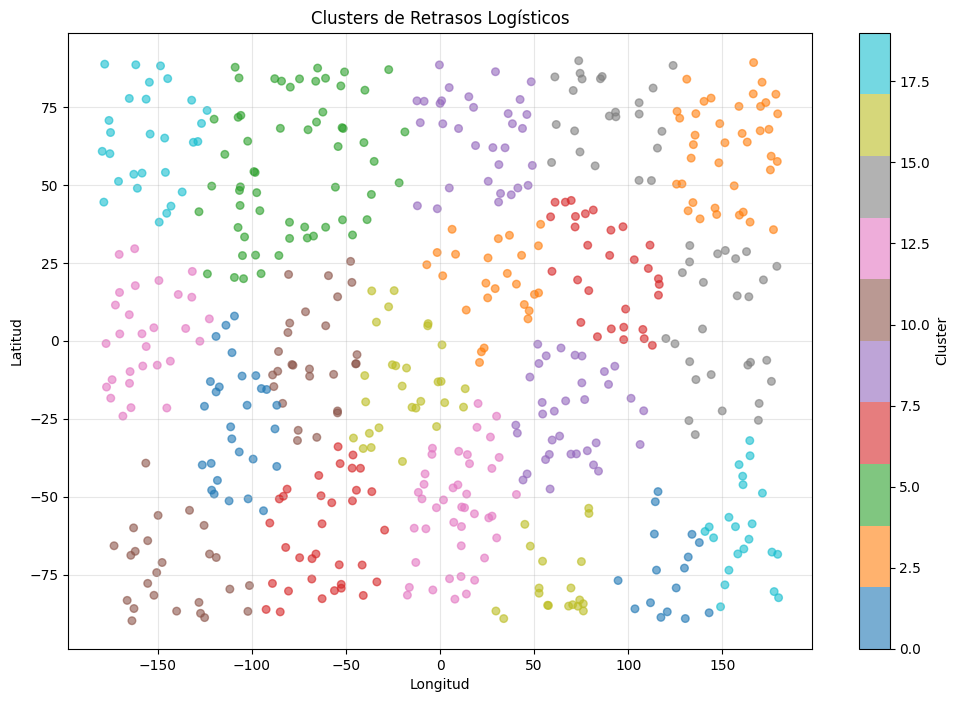

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Filtrar solo retrasos (Logistics_Delay == 1)
delay_df = df_logistics[df_logistics['Logistics_Delay'] == 1][['Latitude', 'Longitude']]

# Aplicar K-Means (ej: 5 clusters)
kmeans = KMeans(n_clusters=20, random_state=42)
delay_df['Cluster'] = kmeans.fit_predict(delay_df[['Latitude', 'Longitude']])

# Visualizar clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(delay_df['Longitude'], delay_df['Latitude'], c=delay_df['Cluster'], cmap='tab10', s=30, alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Clusters de Retrasos Logísticos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(alpha=0.3)
plt.show()

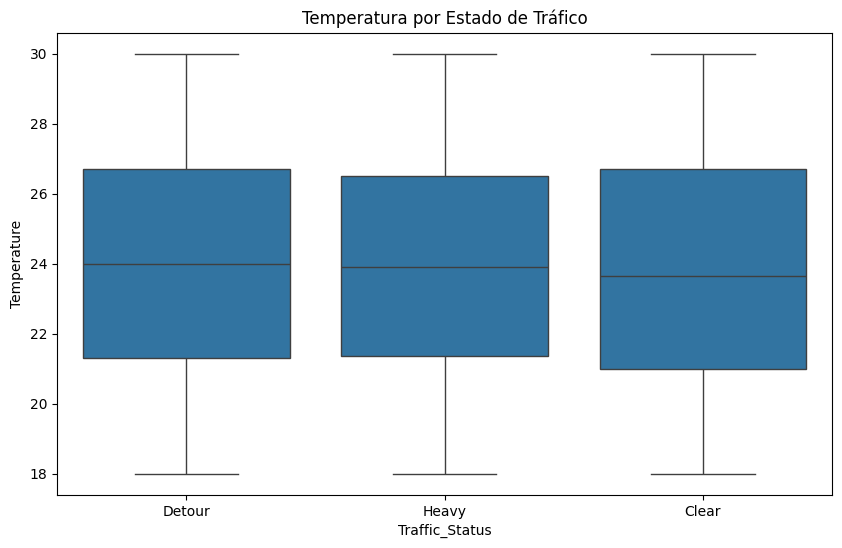

In [ ]:
# Boxplot de Temperatura por Estado de Tráfico
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_logistics, x='Traffic_Status', y='Temperature')
plt.title('Temperatura por Estado de Tráfico')
plt.show()

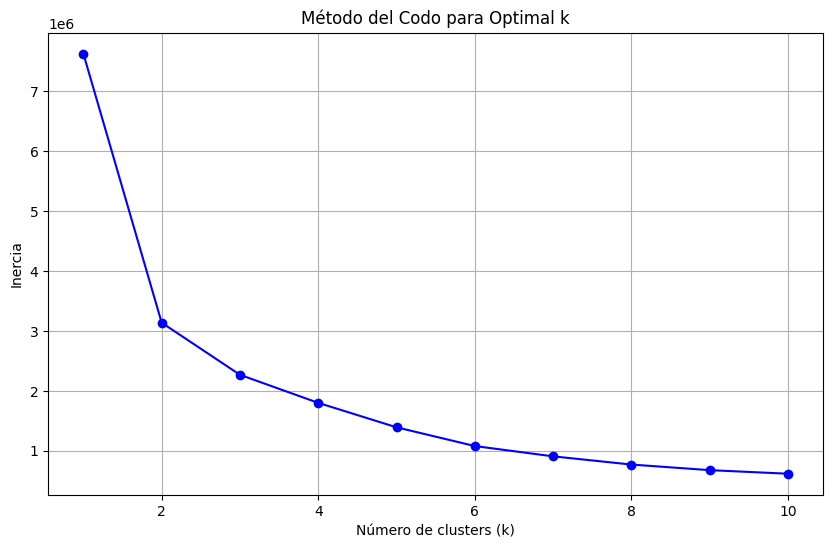

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Filtrar solo retrasos
delay_df = df_logistics[df_logistics['Logistics_Delay'] == 1][['Latitude', 'Longitude']]

# Calcular inercia para diferentes valores de k
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(delay_df)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Optimal k')
plt.grid(True)
plt.show()


Probabilidad de que dado un retraso, sea de cada truck:
Asset_ID
Truck_10    12.01
Truck_4     11.13
Truck_8     10.95
Truck_7     10.60
Truck_3     10.25
Truck_2      9.89
Truck_6      9.54
Truck_9      9.36
Truck_5      8.13
Truck_1      8.13
Name: count, dtype: float64


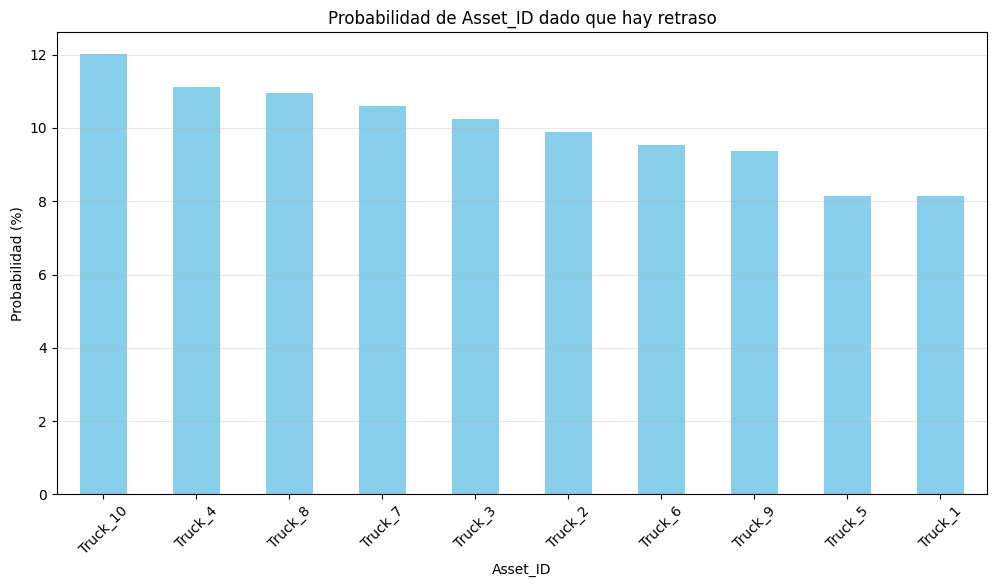

In [ ]:
# Calcular probabilidades condicionales P(Asset_ID | Delay)
delay_count_by_truck = df_logistics[df_logistics['Logistics_Delay'] == 1]['Asset_ID'].value_counts()
total_delays = len(df_logistics[df_logistics['Logistics_Delay'] == 1])

probabilities = (delay_count_by_truck / total_delays * 100).round(2)

print("Probabilidad de que dado un retraso, sea de cada truck:")
print(probabilities)

# Gráfico de barras
plt.figure(figsize=(12, 6))
probabilities.plot(kind='bar', color='skyblue')
plt.title('Probabilidad de Asset_ID dado que hay retraso')
plt.xlabel('Asset_ID')
plt.ylabel('Probabilidad (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
## proabilida de retraso por temperatura
### Conclusion: Parece no haber impacto en si habrá delay o no

# Definir umbrales (puedes ajustarlos)
temp_threshold = df_logistics['Temperature'].median()
humidity_threshold = df_logistics['Humidity'].median()

print(f"Umbral temperatura: {temp_threshold:.1f}°C")
print(f"Umbral humedad: {humidity_threshold:.1f}%")

# Probabilidad de temperatura alta dado retraso
high_temp_delays = len(df_logistics[(df_logistics['Logistics_Delay'] == 1) & (df_logistics['Temperature'] > temp_threshold)])
total_delays = len(df_logistics[df_logistics['Logistics_Delay'] == 1])

p_high_temp_given_delay = round(high_temp_delays / total_delays * 100,2)
p_low_temp_given_delay = 100 - p_high_temp_given_delay

# Probabilidad de humedad alta dado retraso
high_humidity_delays = len(df_logistics[(df_logistics['Logistics_Delay'] == 1) & (df_logistics['Humidity'] > humidity_threshold)])
p_high_humidity_given_delay = round(high_humidity_delays / total_delays * 100,2)
p_low_humidity_given_delay = 100 - p_high_humidity_given_delay

print(f"\nDado que hay retraso:")
print(f"Probabilidad de temperatura alta (> {temp_threshold}°C): {p_high_temp_given_delay}%")
print(f"Probabilidad de temperatura baja: {p_low_temp_given_delay}%")
print(f"Probabilidad de humedad alta (> {humidity_threshold}%): {p_high_humidity_given_delay}%")
print(f"Probabilidad de humedad baja: {p_low_humidity_given_delay}%")

Umbral temperatura: 23.8°C
Umbral humedad: 65.2%

Dado que hay retraso:
Probabilidad de temperatura alta (> 23.8°C): 48.94%
Probabilidad de temperatura baja: 51.06%
Probabilidad de humedad alta (> 65.2%): 50.18%
Probabilidad de humedad baja: 49.82%


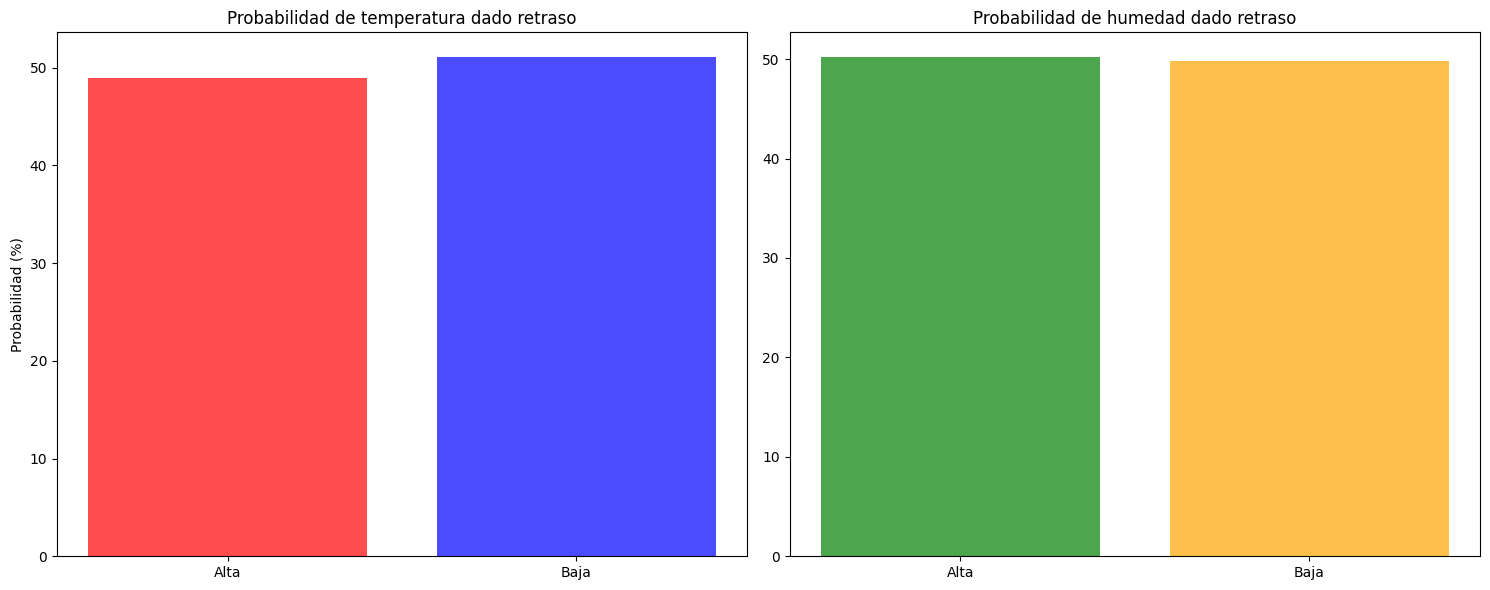

In [ ]:
# Gráfico comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Temperatura
ax1.bar(['Alta', 'Baja'], [p_high_temp_given_delay, p_low_temp_given_delay],
        color=['red', 'blue'], alpha=0.7)
ax1.set_title('Probabilidad de temperatura dado retraso')
ax1.set_ylabel('Probabilidad (%)')

# Humedad
ax2.bar(['Alta', 'Baja'], [p_high_humidity_given_delay, p_low_humidity_given_delay],
        color=['green', 'orange'], alpha=0.7)
ax2.set_title('Probabilidad de humedad dado retraso')

plt.tight_layout()
plt.show()

Enfoque mejorado: Análisis de zonas de riesgo
Paso 1: Crear métrica de riesgo por ubicación

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN  # Mejor para densidad
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular tasa de retraso por coordenadas (agrupando puntos cercanos)
df_logistics['delay_rate'] = df_logistics.groupby(['Latitude', 'Longitude'])['Logistics_Delay'].transform('mean')

# Crear dataset de ubicaciones únicas con su tasa de retraso
location_risk = df_logistics.groupby(['Latitude', 'Longitude']).agg({
    'Logistics_Delay': 'mean',
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Traffic_Status': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'Waiting_Time': 'mean'
}).reset_index()

location_risk.rename(columns={'Logistics_Delay': 'delay_probability'}, inplace=True)
print("Dataset de riesgo por ubicación:")
print(location_risk.head())

Dataset de riesgo por ubicación:
   Latitude  Longitude  delay_probability  Temperature  Humidity  \
0  -89.7915    85.8036                0.0         20.5      71.2   
1  -89.7784  -163.7965                1.0         28.3      76.2   
2  -89.0981    33.8294                1.0         18.6      77.9   
3  -89.0793   130.3362                1.0         22.8      76.1   
4  -88.7760  -125.1628                1.0         21.5      51.0   

  Traffic_Status  Waiting_Time  
0         Detour          44.0  
1          Clear          53.0  
2          Heavy          30.0  
3         Detour          35.0  
4          Heavy          59.0  


In [ ]:
## clusterizacion por densidad
# Normalizar coordenadas para el clustering
from sklearn.preprocessing import StandardScaler

coords = location_risk[['Latitude', 'Longitude']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# DBSCAN para encontrar zonas densas
dbscan = DBSCAN(eps=0.3, min_samples=5)  # Ajustar estos parámetros
location_risk['zone_cluster'] = dbscan.fit_predict(coords_scaled)

print(f"Número de zonas identificadas: {len(set(location_risk['zone_cluster'])) - 1}")

Número de zonas identificadas: 0


In [ ]:
# Calcular métricas por zona
zone_analysis = location_risk.groupby('zone_cluster').agg({
    'delay_probability': ['mean', 'count'],
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Traffic_Status': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
}).round(3)

zone_analysis.columns = ['avg_delay_rate', 'num_locations', 'avg_temperature', 'avg_humidity', 'common_traffic']
zone_analysis = zone_analysis[zone_analysis.index != -1]  # Remover outliers

print("Análisis de zonas de riesgo:")
print(zone_analysis.sort_values('avg_delay_rate', ascending=False))

Análisis de zonas de riesgo:
              avg_delay_rate  num_locations  avg_temperature  avg_humidity  \
zone_cluster                                                                 
0                      0.566           1000           23.894        65.042   

             common_traffic  
zone_cluster                 
0                    Detour  


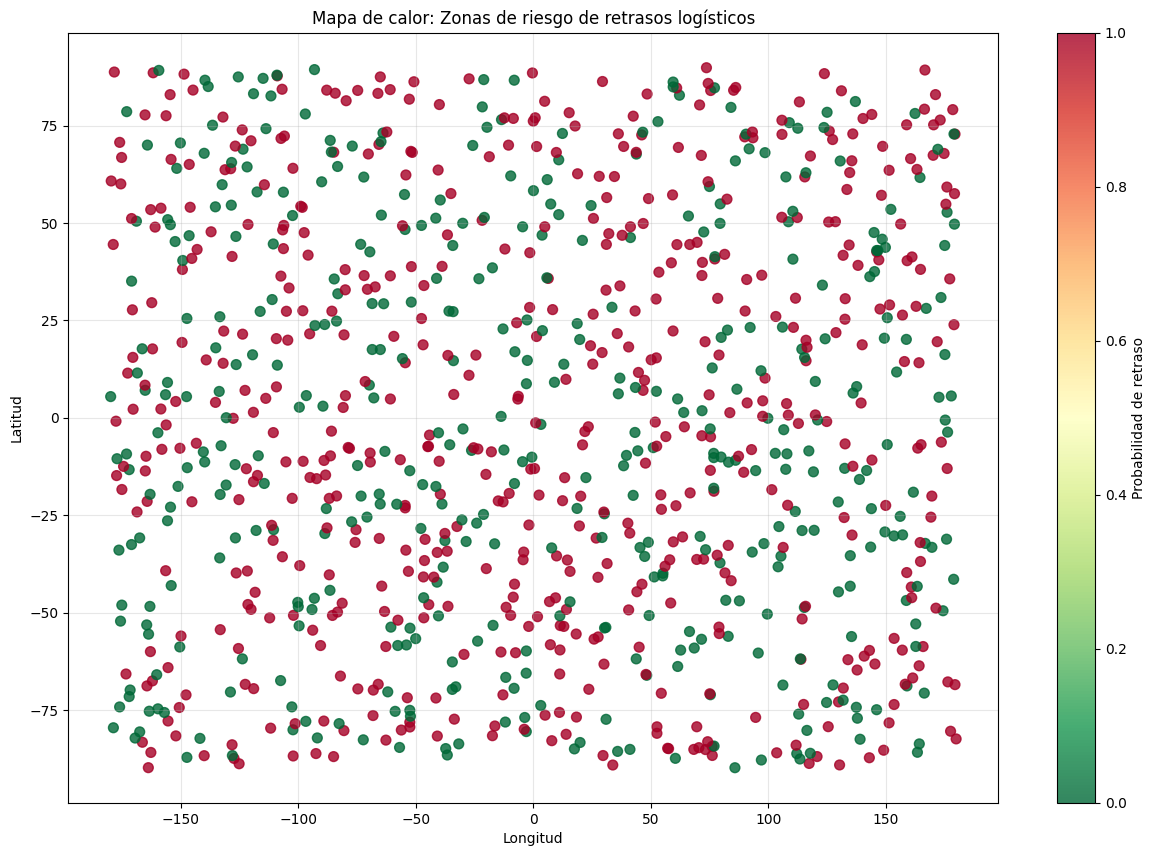

In [ ]:
plt.figure(figsize=(15, 10))

# Scatter plot coloreado por probabilidad de retraso
scatter = plt.scatter(location_risk['Longitude'], location_risk['Latitude'],
                     c=location_risk['delay_probability'],
                     cmap='RdYlGn_r',  # Rojo (alto riesgo) a Verde (bajo riesgo)
                     s=50, alpha=0.8)

plt.colorbar(scatter, label='Probabilidad de retraso')
plt.title('Mapa de calor: Zonas de riesgo de retrasos logísticos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(alpha=0.3)
plt.show()

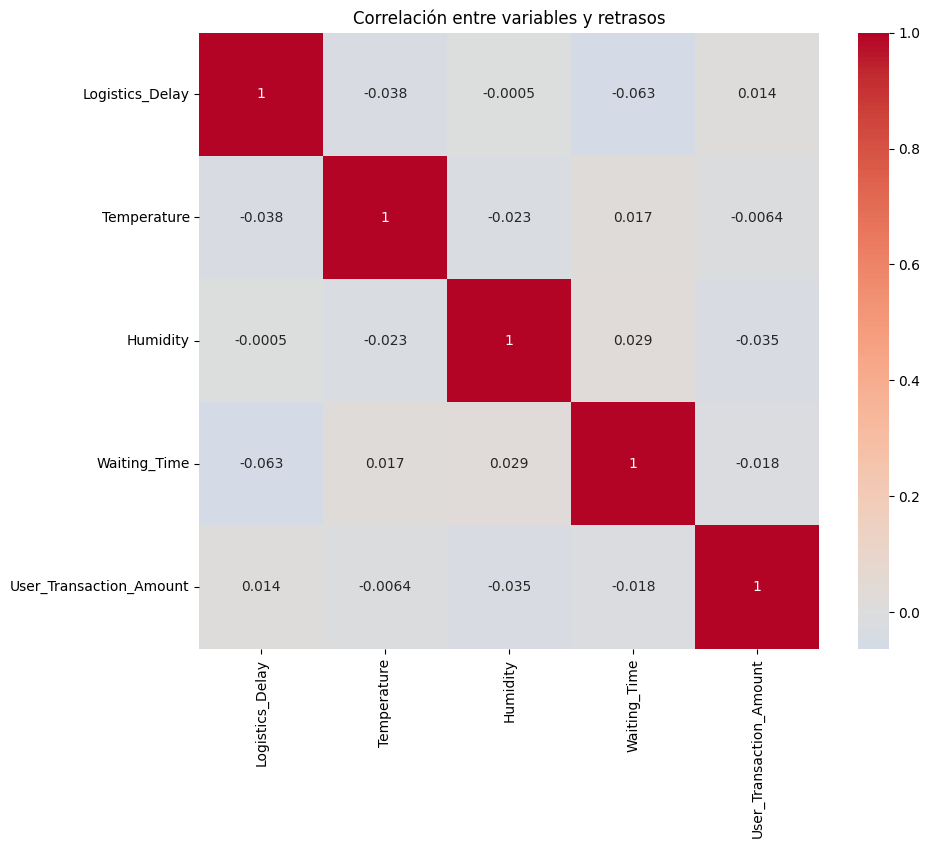


Probabilidad de retraso por tipo de tráfico:
                delay_probability  total_shipments
Traffic_Status                                    
Heavy                     1.00000              327
Detour                    0.35942              345
Clear                     0.35061              328


In [ ]:
# Factores correlacionados con retrasos
correlation_matrix = df_logistics[['Logistics_Delay', 'Temperature', 'Humidity',
                        'Waiting_Time', 'User_Transaction_Amount']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre variables y retrasos')
plt.show()

# Análisis de retrasos por tipo de tráfico
traffic_delay_analysis = df_logistics.groupby('Traffic_Status')['Logistics_Delay'].agg(['mean', 'count'])
traffic_delay_analysis.columns = ['delay_probability', 'total_shipments']
traffic_delay_analysis = traffic_delay_analysis.sort_values('delay_probability', ascending=False)

print("\nProbabilidad de retraso por tipo de tráfico:")
print(traffic_delay_analysis)

In [ ]:
# 1. Probabilidad marginal de cada estado de tráfico
traffic_distribution = df_logistics['Traffic_Status'].value_counts(normalize=True).round(3) * 100
print("Distribución de estados de tráfico:")
print(traffic_distribution)
print("\n" + "="*50 + "\n")

# 2. Probabilidad condicional P(Retraso | Traffic_Status)
delay_by_traffic = df_logistics.groupby('Traffic_Status')['Logistics_Delay'].agg([
    'mean',  # Probabilidad de retraso
    'count'   # Total de envíos
]).round(3)

delay_by_traffic.columns = ['prob_retraso', 'total_envios']
delay_by_traffic['prob_retraso_pct'] = (delay_by_traffic['prob_retraso'] * 100).round(1)

print("Probabilidad de retraso por estado de tráfico:")
print(delay_by_traffic.sort_values('prob_retraso', ascending=False))
print("\n" + "="*50 + "\n")

# 3. Análisis estadístico más detallado
traffic_delay_detail = df_logistics.groupby('Traffic_Status').agg({
    'Logistics_Delay': ['mean', 'sum', 'count'],
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Waiting_Time': 'mean'
}).round(2)

traffic_delay_detail.columns = [
    'prob_retraso', 'total_retrasos', 'total_envios',
    'temp_promedio', 'humedad_promedio', 'tiempo_espera_promedio'
]

traffic_delay_detail['prob_retraso_pct'] = (traffic_delay_detail['prob_retraso'] * 100).round(1)
traffic_delay_detail = traffic_delay_detail.sort_values('prob_retraso', ascending=False)

print("Análisis detallado por estado de tráfico:")
print(traffic_delay_detail)


Distribución de estados de tráfico:
Traffic_Status
Detour    34.5
Clear     32.8
Heavy     32.7
Name: proportion, dtype: float64


Probabilidad de retraso por estado de tráfico:
                prob_retraso  total_envios  prob_retraso_pct
Traffic_Status                                              
Heavy                  1.000           327             100.0
Detour                 0.359           345              35.9
Clear                  0.351           328              35.1


Análisis detallado por estado de tráfico:
                prob_retraso  total_retrasos  total_envios  temp_promedio  \
Traffic_Status                                                              
Heavy                   1.00             327           327          23.87   
Detour                  0.36             124           345          23.99   
Clear                   0.35             115           328          23.81   

                humedad_promedio  tiempo_espera_promedio  prob_retraso_pct  
Traffic_St

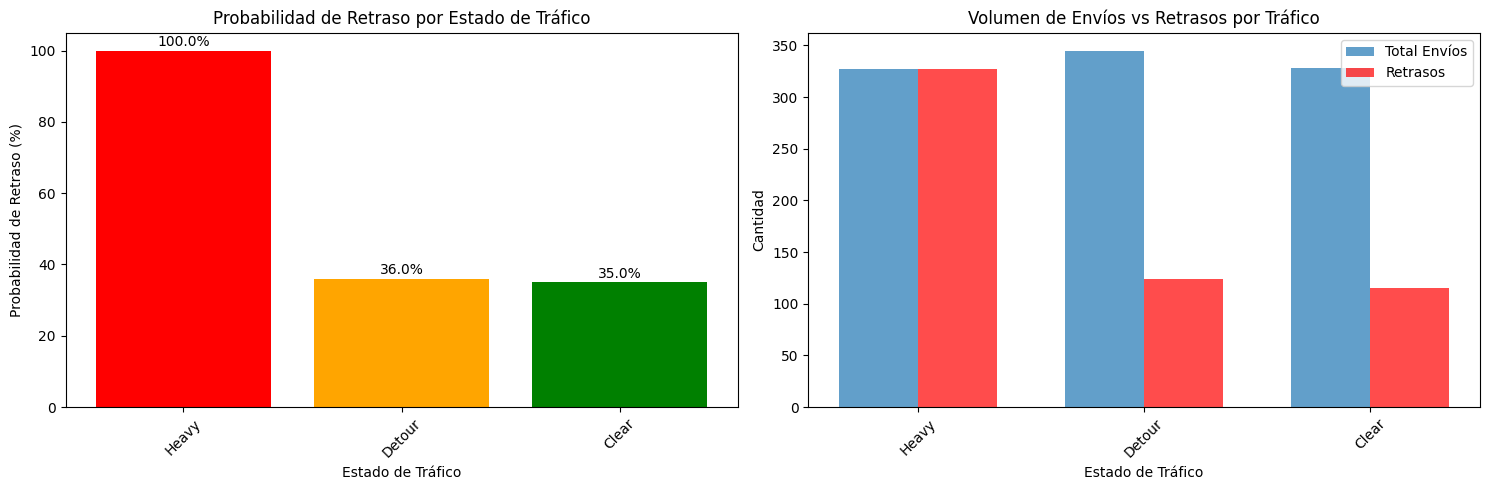

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
## Se concluye que si hay retras ocuand otrafico es alto
plt.figure(figsize=(15, 5))

# Gráfico 1: Probabilidad de retraso por estado de tráfico
plt.subplot(1, 2, 1)
bars = plt.bar(traffic_delay_detail.index, traffic_delay_detail['prob_retraso_pct'],
               color=['red', 'orange', 'green', 'blue'])
plt.title('Probabilidad de Retraso por Estado de Tráfico')
plt.xlabel('Estado de Tráfico')
plt.ylabel('Probabilidad de Retraso (%)')
plt.xticks(rotation=45)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height}%', ha='center', va='bottom')

# Gráfico 2: Total de envíos vs retrasos por estado de tráfico
plt.subplot(1, 2, 2)
width = 0.35
x = range(len(traffic_delay_detail))
plt.bar(x, traffic_delay_detail['total_envios'], width, label='Total Envíos', alpha=0.7)
plt.bar([i + width for i in x], traffic_delay_detail['total_retrasos'], width,
        label='Retrasos', alpha=0.7, color='red')
plt.title('Volumen de Envíos vs Retrasos por Tráfico')
plt.xlabel('Estado de Tráfico')
plt.ylabel('Cantidad')
plt.xticks([i + width/2 for i in x], traffic_delay_detail.index, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

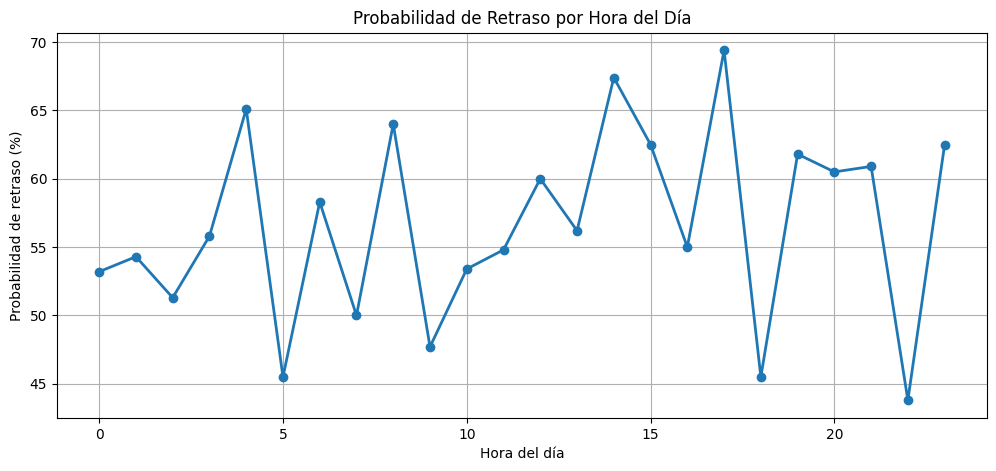

In [ ]:
# Extraer hora del día
df_logistics['hour'] = pd.to_datetime(df_logistics['Timestamp']).dt.hour

# Retrasos por hora
delay_by_hour = df_logistics.groupby('hour')['Logistics_Delay'].agg(['mean', 'count']).round(3)
delay_by_hour['delay_rate_pct'] = (delay_by_hour['mean'] * 100).round(1)

plt.figure(figsize=(12, 5))
plt.plot(delay_by_hour.index, delay_by_hour['delay_rate_pct'], marker='o', linewidth=2)
plt.title('Probabilidad de Retraso por Hora del Día')
plt.xlabel('Hora del día')
plt.ylabel('Probabilidad de retraso (%)')
plt.grid(True)
plt.show()

In [ ]:
# ¿Los trucks muy utilizados tienen más retrasos?
## Parece que el aset utilizatio nno tieme impacto
utilization_delay = df_logistics.groupby(pd.qcut(df_logistics['Asset_Utilization'], 4))['Logistics_Delay'].mean().round(3)

print("Probabilidad de retraso por nivel de utilización:")
print(utilization_delay)

Probabilidad de retraso por nivel de utilización:
Asset_Utilization
(59.999, 69.475]    0.576
(69.475, 79.25]     0.580
(79.25, 89.425]     0.548
(89.425, 100.0]     0.560
Name: Logistics_Delay, dtype: float64


/tmp/ipython-input-527658687.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



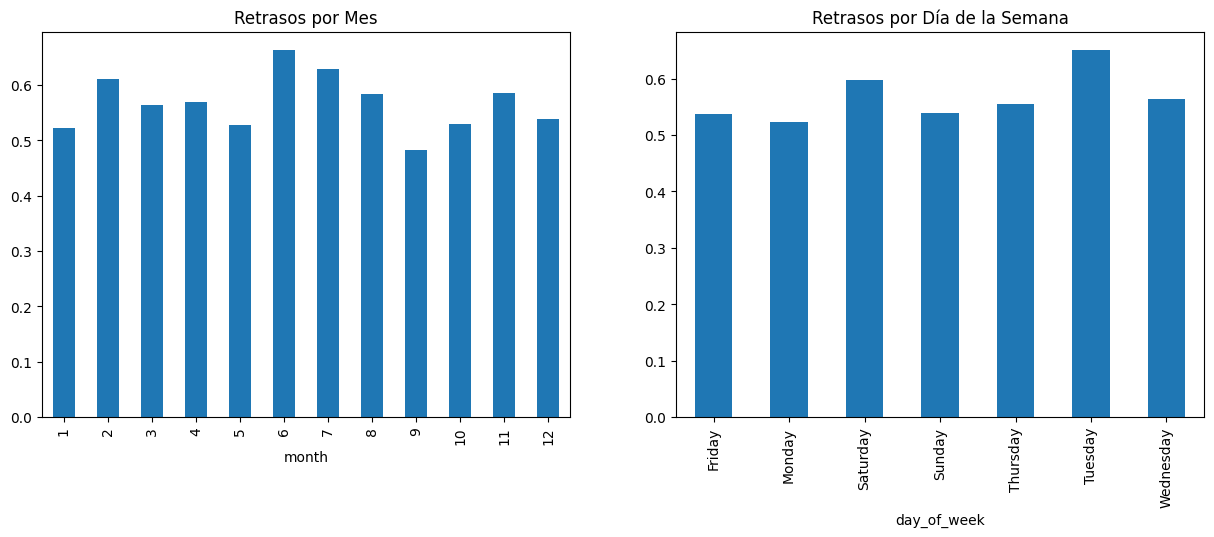

In [ ]:
df_logistics['month'] = pd.to_datetime(df_logistics['Timestamp']).dt.month
df_logistics['day_of_week'] = pd.to_datetime(df_logistics['Timestamp']).dt.day_name()

delay_by_month = df_logistics.groupby('month')['Logistics_Delay'].mean()
delay_by_day = df_logistics.groupby('day_of_week')['Logistics_Delay'].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
delay_by_month.plot(kind='bar', ax=ax1, title='Retrasos por Mes')
delay_by_day.plot(kind='bar', ax=ax2, title='Retrasos por Día de la Semana')
plt.show()

In [ ]:
# Combinar ubicación con múltiples variables
geo_analysis = df_logistics.groupby(['Latitude', 'Longitude']).agg({
    'Logistics_Delay': 'mean',
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Traffic_Status': lambda x: x.mode()[0],
    'Waiting_Time': 'mean'
}).round(2).sort_values('Logistics_Delay', ascending=False)

print("Top 10 zonas de mayor riesgo con sus características:")
print(geo_analysis.head(10))

Top 10 zonas de mayor riesgo con sus características:
                    Logistics_Delay  Temperature  Humidity Traffic_Status  \
Latitude Longitude                                                          
 89.8701  73.6867               1.0         26.9      70.0          Heavy   
 89.2765  166.6548              1.0         18.9      55.5          Heavy   
-89.7784 -163.7965              1.0         28.3      76.2          Clear   
-89.0981  33.8294               1.0         18.6      77.9          Heavy   
-89.0793  130.3362              1.0         22.8      76.1         Detour   
-88.7760 -125.1628              1.0         21.5      51.0          Heavy   
 86.3368  29.4478               1.0         23.4      59.9         Detour   
 86.2679 -50.7895               1.0         28.0      67.2          Heavy   
 85.8393  74.4208               1.0         30.0      75.4          Heavy   
 84.8041  86.1533               1.0         20.6      79.3          Heavy   

                    W

In [ ]:
# Dado que hay un retraso, ¿cuál es la probabilidad de que ocurra en cierto día de la semana o en cierto mes?
# 1. Extraer mes y día de la semana
df_logistics['Timestamp'] = pd.to_datetime(df_logistics['Timestamp'])
df_logistics['month'] = df_logistics['Timestamp'].dt.month
df_logistics['day_of_week'] = df_logistics['Timestamp'].dt.day_name()

# 2. Filtrar solo los retrasos
retrasos_df = df_logistics[df_logistics['Logistics_Delay'] == 1]

# 3. Probabilidad condicional: P(Día de la semana | Retraso)
prob_dia_retraso = (retrasos_df['day_of_week'].value_counts(normalize=True) * 100).round(2)
prob_dia_retraso = prob_dia_retraso.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

print("Dado que hay un retraso, probabilidad por día de la semana:")
print(prob_dia_retraso)
print("\n" + "="*50 + "\n")

# 4. Probabilidad condicional: P(Mes | Retraso)
prob_mes_retraso = (retrasos_df['month'].value_counts(normalize=True) * 100).round(2)
prob_mes_retraso = prob_mes_retraso.reindex(range(1, 13))

print("Dado que hay un retraso, probabilidad por mes:")
print(prob_mes_retraso)


Dado que hay un retraso, probabilidad por día de la semana:
day_of_week
Monday       14.13
Tuesday      16.08
Wednesday    15.72
Thursday     13.25
Friday       13.96
Saturday     14.66
Sunday       12.19
Name: proportion, dtype: float64


Dado que hay un retraso, probabilidad por mes:
month
1     8.48
2     8.30
3     9.36
4     8.66
5     6.89
6     9.01
7     9.54
8     7.95
9     7.07
10    7.77
11    8.48
12    8.48
Name: proportion, dtype: float64


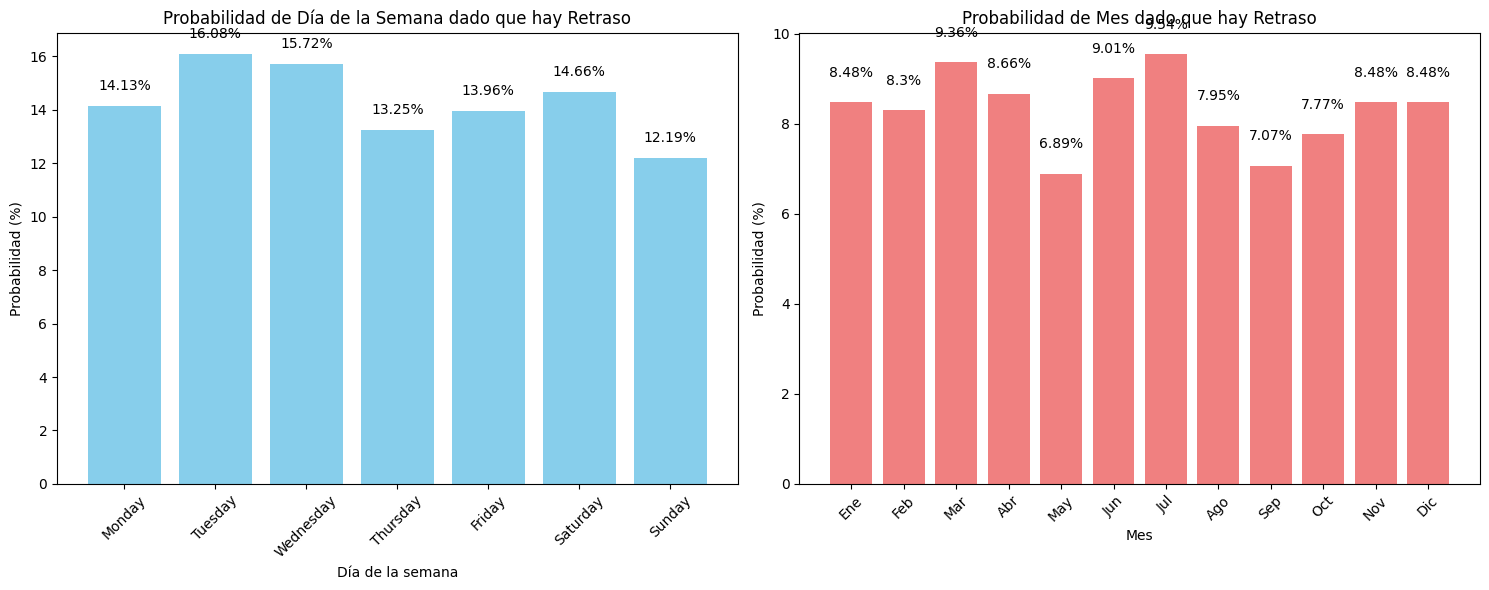

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Probabilidad por día de la semana
bars1 = ax1.bar(prob_dia_retraso.index, prob_dia_retraso.values, color='skyblue')
ax1.set_title('Probabilidad de Día de la Semana dado que hay Retraso')
ax1.set_xlabel('Día de la semana')
ax1.set_ylabel('Probabilidad (%)')
ax1.tick_params(axis='x', rotation=45)

# Añadir valores en las barras
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height}%', ha='center', va='bottom')

# Gráfico 2: Probabilidad por mes
meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
         'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
prob_mes_retraso.index = meses[:len(prob_mes_retraso)]

bars2 = ax2.bar(prob_mes_retraso.index, prob_mes_retraso.values, color='lightcoral')
ax2.set_title('Probabilidad de Mes dado que hay Retraso')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Probabilidad (%)')
ax2.tick_params(axis='x', rotation=45)

# Añadir valores en las barras
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Probabilidad conjunta: Mes y Día de la semana dado Retraso (%):
day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Ene            0.88     1.94       0.88      1.06    1.24      1.77    0.71
Feb            0.88     1.77       1.77      0.88    0.71      1.41    0.88
Mar            0.88     1.06       1.06      1.77    2.12      1.59    0.88
Abr            1.59     1.94       1.06      1.59    0.88      0.88    0.71
May            0.71     0.71       1.06      1.59    1.41      0.88    0.53
Jun            1.41     1.59       0.88      0.71    1.24      1.94    1.24
Jul            1.41     1.94       1.77      1.06    1.24      1.24    0.88
Ago            1.24     1.59       1.24      0.88    1.24      0.88    0.88
Sep            1.24     0.53       1.06      1.77    1.06      0.35    1.06
Oct            0.88     1.41       2.30      0.71    1.06      0.53    0.88
Nov            1.06     1.06       1.59      0.35    1.24      1.94    1.24
Dic            1.94     

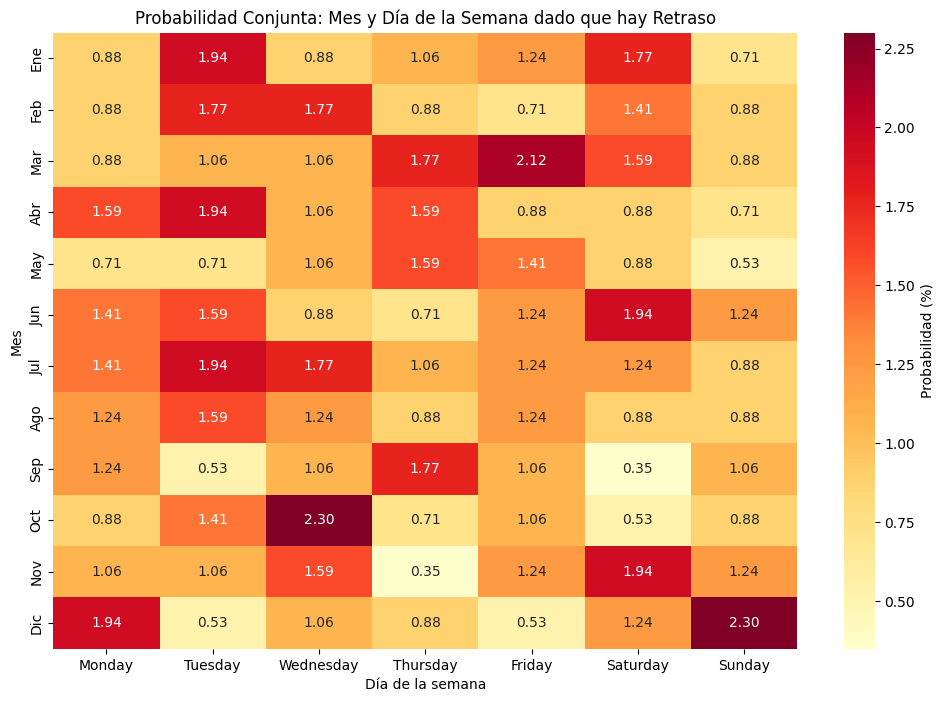

In [ ]:
# Probabilidad conjunta: P(Mes y Día de la semana | Retraso)
prob_mes_dia = pd.crosstab(
    index=retrasos_df['month'],
    columns=retrasos_df['day_of_week'],
    normalize=True
).round(4) * 100

# Reordenar columnas y filas
prob_mes_dia = prob_mes_dia.reindex(columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
prob_mes_dia.index = meses[:len(prob_mes_dia)]

print("Probabilidad conjunta: Mes y Día de la semana dado Retraso (%):")
print(prob_mes_dia)

# Heatmap de probabilidades conjuntas
plt.figure(figsize=(12, 8))
sns.heatmap(prob_mes_dia, annot=True, cmap='YlOrRd', fmt='.2f', cbar_kws={'label': 'Probabilidad (%)'})
plt.title('Probabilidad Conjunta: Mes y Día de la Semana dado que hay Retraso')
plt.xlabel('Día de la semana')
plt.ylabel('Mes')
plt.show()